# Creating a Kaggle Workflow

In this project, we will create a workflow for the Kaggle Titanic competition.  We will create a pipeline of functions to allow for easier experimentation and multiple iterations.

In this dataset, we are given some information about passengers aboard the Titanic, as well as whether or not they survived.  Our goal is to use this data to predict the survival of the test data from Kaggle.  More information is available [here](https://www.kaggle.com/c/titanic/data).

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# import our datasets
# data for training
train = pd.read_csv('train.csv')
# data for testing, renamed holdout
holdout = pd.read_csv('test.csv')

In [3]:
# review first few lines of train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Processing

To perform our data processing, we will begin by loading in all of our previous work to create data cleaning functions.  We will then create a function that combines these functions to process the train and holdout dataframes.

In [4]:
# use %load to load the functions we previously built
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
# create a function that applies these functions to the dataframe:
# process_missing(), process_age(), process_fare(), process_titles(), process_cabin()
# also create dummies for the following columns:
# Age_categories, Fare_categories, Title, Cabin_type, Sex

def preprocessing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ['Age_categories', 'Fare_categories', 'Title', 
            'Cabin_type', 'Sex']
    for col in cols:
        df = create_dummies(df, col)
    
    return df

In [6]:
# apply the preprocessing function on train and holdout
train = preprocessing(train)
holdout = preprocessing(holdout)

In [7]:
# review data after preprocessing
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


## Data Exploration

Let's begin the next step by exploring our data further.  We will begin by looking at `SibSp` and `Parch`, which we haven't yet explored.

In [8]:
# look at the distribution of values in these columns
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [9]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

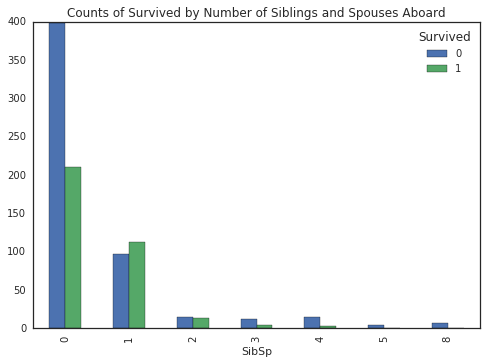

In [10]:
# review survival by number of SibSp
sibsp_pivot = pd.pivot_table(train, index='SibSp', columns='Survived', 
                             values='PassengerId', aggfunc='count')
sibsp_pivot.plot(kind='bar')
plt.title('Counts of Survived by Number of Siblings and Spouses Aboard')
plt.show()

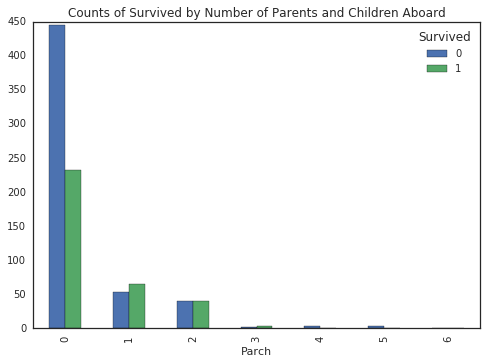

In [11]:
# review survival by number of Parch
parch_pivot = pd.pivot_table(train, index='Parch', columns='Survived', 
                             values='PassengerId', aggfunc='count')
parch_pivot.plot(kind='bar')
plt.title('Counts of Survived by Number of Parents and Children Aboard')
plt.show()

In [12]:
# create a new column for total family members aboard
data_explore = train.copy()
data_explore['family'] = data_explore['SibSp'] + data_explore['Parch']
data_explore['family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: family, dtype: int64

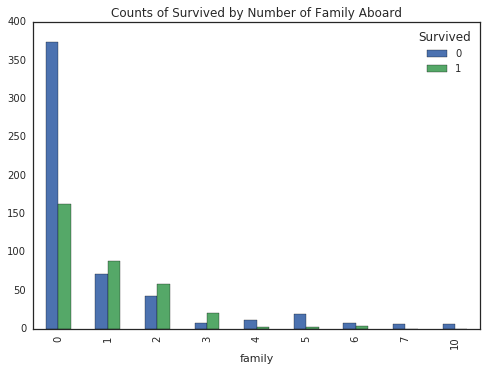

In [13]:
# review survival rates based on this new feature
family_pivot = pd.pivot_table(data_explore, index='family', columns='Survived', 
                             values='PassengerId', aggfunc='count')
family_pivot.plot(kind='bar')
plt.title('Counts of Survived by Number of Family Aboard')
plt.show()

From the above, we can see that for people traveling alone, about twice as many died as survived.  For those will small numbers of family aboard, slightly more survived than died.  For those with larger numbers of family members on board (four or more), however, more died than survived.

It appears that we can create some new features for modeling - one to indicate if someone is traveling alone, one to indicate a small number of family on board, and one to indicate a large number of family on board.

## Engineer New Features

We can now create a function to create these new features that we identified above.  Once we create this function, we can then apply it to both train and holdout.

In [14]:
# create function to create three indicator variables:
# is_alone - no family on board
# small_group - one to three family members on board
# large_group - more than three family members on board

def process_family(df):
    df['family'] = df[['SibSp','Parch']].sum(axis=1)
    df['is_alone'] = 0
    df.loc[df['family'] == 0, 'is_alone'] = 1
    df['small_group'] = 0
    df.loc[(df['family'] > 0) & (df['family'] < 4), 'small_group'] = 1
    df['large_group'] = 0
    df.loc[df['family'] > 3, 'large_group'] = 1
    df = df.drop(['family'], axis=1)
    return df

In [15]:
# apply the function to train and holdout
train = process_family(train)
holdout = process_family(holdout)

In [16]:
# confirm the results of our function
train[['is_alone', 'small_group', 'large_group']].head()

,is_alone,small_group,large_group
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0


## Feature Selection

The next step in our process is to select the best performing features that we would like to use in our final model.  We will use scikit-learn's RFECV (recursive feature elimination and cross validation) to automate the selection of the best features.  Using this requires an estimator, and since we previously discovered that our Random Forest model performed best (out of a Logistic model, k-Nearest Neighbors model, and Random Forest model), we will use that as the estimator.

We will create a function for this feature selection process that will pare down our columns to usable ones and use RFECV to determine the best features out of those that remain.

In [17]:
# create a function for feature selection
def select_features(df):
    # remove columns that are not numeric
    df = df.select_dtypes(include='number')
    # remove columns with any missing values
    df = df.dropna(axis=1)
    
    # create all_X (our features) and all_y (our target)
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    # perform recursive feature elimination
    estimator = RandomForestClassifier(random_state=1)
    selector = RFECV(estimator, cv=10)
    selector = selector.fit(all_X, all_y)
    
    # collect the selected features as a list
    best_features = list(all_X.columns[selector.support_])
    # print out the features
    print('Best Features:\n', best_features)
    
    return best_features

In [18]:
# use the select_features function on train to determine best features
cols = select_features(train)

Best Features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'is_alone', 'small_group', 'large_group']


## Model Selection and Tuning

The next step in the process is to perform model selection and tuning.  We will do this by writing a function to test out three different models and use grid search to find the best parameters.

In [19]:
# create a function for model selection and tuning

def select_model(df, features):
    # create all_X (our features) and all_y (our target)
    all_X = df[features]
    all_y = df['Survived']
    
    # create list of dictionaries storing model name, estimator, and hyperparameters
    model_list = [
        {
            'name': 'Logistic Regression',
            'estimator': LogisticRegression(),
            'hyperparameters': 
            {
                'solver': ['newton-cg', 'lbfgs', 'liblinear']
            }
        },
        {
            'name': 'k-Nearest Neighbors Classifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
            {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
        },
        {
            'name': 'Random Forest Classifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters':
            {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5]
            }
        }
    ]
    
    # iterate over the list of dictionaries of models
    for model in model_list:
        print('Model: ', model['name'])
        # instantiate grid search
        grid = GridSearchCV(model['estimator'], 
                            param_grid = model['hyperparameters'],
                            cv = 10)
        # fit and store best parameters, score, and estimator
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        # print the best parameters and score
        print('best parameters: ', model['best_params'])
        print('best score: ', model['best_score'])
        print('\n')
    
    # return list of dictionaries
    return model_list

In [20]:
# use the above function to determine the best models for train
# use the features we identified above in feature selection
best_models = select_model(train, cols)

Model:  Logistic Regression
best parameters:  {'solver': 'newton-cg'}
best score:  0.8237934904601572


Model:  k-Nearest Neighbors Classifier
best parameters:  {'p': 1, 'n_neighbors': 3, 'algorithm': 'kd_tree', 'weights': 'uniform'}
best score:  0.7890011223344556


Model:  Random Forest Classifier
best parameters:  {'n_estimators': 9, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1}
best score:  0.8428731762065096




From the above, we see that the Random Forest Model is still the model that is scoring highest, with the Logistic Regression as a close second.

## Submitting to Kaggle

The last step in the workflow is to submit a predictions file to Kaggle.  To do so, we will select our model, make predictions on the holdout data, create a submissions dataframe in the format specified by Kaggle, and save that dataframe as a CSV file.

Let's create a function to perform these steps.

In [21]:
# create the submission file function

def save_submission_file(model, features, filename='submission.csv'):
    # make predictions on holdout
    holdout_predictions = model.predict(holdout[features])
    
    # create submissions dataframe
    submission = pd.DataFrame({
        'PassengerId': holdout['PassengerId'],
        'Survived': holdout_predictions
    })
    
    # save as CSV file (with no index so no extra column)
    submission.to_csv(filename, index=False)

In [22]:
# create submission file using best random forest model
best_rf_model = best_models[2]['best_estimator']
save_submission_file(best_rf_model, cols)